![banner.png](banner.png)

<h2 style="color:#de4a48; background-color:#fce19a; padding: 10px; text-align:left; border: 1px solid #fce19a;">Imports</h2>

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, split, min, max, count, avg, lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import os

In [2]:
# os.environ["HADOOP_HOME"] = "D:\\hadoop"
# os.environ["PATH"] += os.pathsep + os.path.join(os.environ["HADOOP_HOME"], "bin")

In [2]:
spark = SparkSession.builder \
    .appName("IMDbProject") \
    .config("spark.driver.memory", "4g") \
    .config("spark.hadoop.security.authentication", "simple") \
    .getOrCreate()

In [4]:
# Confirm Spark is running
print(f"Spark Version: {spark.version}")

Spark Version: 3.5.5


In [ ]:
# spark.conf.set("spark.sql.shuffle.partitions", "4")
# spark.conf.set("spark.executor.memory", "2g")

<h2 style="color:#de4a48; background-color:#fce19a; padding: 10px; text-align:left; border: 1px solid #fce19a;">Load Datasets</h2>

In [4]:
# Paths
IMDB_PATH = '../data/raw/imdb'
TMDB_PATH = '../data/raw/tmdb'
RAW_PARQUET_PATH = '../data/raw_parquet'
PROCESSED_PATH = '../data/processed'

In [5]:
# # Test

# # Load just ratings file
# ratings = spark.read.csv(
#     os.path.join(IMDB_PATH, 'title.ratings.tsv'),
#     sep='\t',
#     header=True,
#     inferSchema=True,
#     nullValue='\\N'
# )

# # Quick check the schema (optional)
# ratings.printSchema()

# # Quick check the data (optional)
# ratings.show(5)

# # Test writing ratings to Parquet (this is the test)
# ratings.write.mode('overwrite').parquet(os.path.join(PROCESSED_PATH, 'ratings.parquet'))

# print("✅ Ratings saved to Parquet successfully!")

In [5]:
# Define schemas based on the provided structure for each IMDb file
schemas = {
    "basics": StructType([
        StructField("tconst", StringType(), True),
        StructField("titleType", StringType(), True),
        StructField("primaryTitle", StringType(), True),
        StructField("originalTitle", StringType(), True),
        StructField("isAdult", IntegerType(), True),
        StructField("startYear", IntegerType(), True),
        StructField("endYear", IntegerType(), True),
        StructField("runtimeMinutes", StringType(), True),
        StructField("genres", StringType(), True)
    ]),
    "akas": StructType([
        StructField("titleId", StringType(), True),
        StructField("ordering", IntegerType(), True),
        StructField("title", StringType(), True),
        StructField("region", StringType(), True),
        StructField("language", StringType(), True),
        StructField("types", StringType(), True),
        StructField("attributes", StringType(), True),
        StructField("isOriginalTitle", IntegerType(), True)
    ]),
    "crew": StructType([
        StructField("tconst", StringType(), True),
        StructField("directors", StringType(), True),
        StructField("writers", StringType(), True)
    ]),
    "episode": StructType([
        StructField("tconst", StringType(), True),
        StructField("parentTconst", StringType(), True),
        StructField("seasonNumber", IntegerType(), True),
        StructField("episodeNumber", IntegerType(), True)
    ]),
    "principals": StructType([
        StructField("tconst", StringType(), True),
        StructField("ordering", IntegerType(), True),
        StructField("nconst", StringType(), True),
        StructField("category", StringType(), True),
        StructField("job", StringType(), True),
        StructField("characters", StringType(), True)
    ]),
    "ratings": StructType([
        StructField("tconst", StringType(), True),
        StructField("averageRating", DoubleType(), True),
        StructField("numVotes", IntegerType(), True)
    ]),
    "names": StructType([
        StructField("nconst", StringType(), True),
        StructField("primaryName", StringType(), True),
        StructField("birthYear", IntegerType(), True),
        StructField("deathYear", IntegerType(), True),
        StructField("primaryProfession", StringType(), True),
        StructField("knownForTitles", StringType(), True)
    ])
}

# Make sure output folders exist
os.makedirs(RAW_PARQUET_PATH, exist_ok=True)
os.makedirs(PROCESSED_PATH, exist_ok=True)

imdb_files = {
    "basics": "title.basics.tsv",
    "akas": "title.akas.tsv",
    "crew": "title.crew.tsv",
    "episode": "title.episode.tsv",
    "principals": "title.principals.tsv",
    "ratings": "title.ratings.tsv",
    "names": "name.basics.tsv"
}

### Load IMDB data to Spark Dataframes

In [6]:
# Load files using predefined schemas
imdb_dfs = {
    key: spark.read.csv(
        os.path.join(IMDB_PATH, filename),
        sep='\t',
        header=True,
        schema=schemas[key],
        nullValue='\\N'
    )
    for key, filename in imdb_files.items()
}

# Display the data for each IMDb file
for name, df in imdb_dfs.items():
    print(f"IMDb - {name}:")
    df.show(5)

IMDb - basics:
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|   NULL|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|   NULL|             5|     Animation,Short|
|tt0000003|    short|        Poor Pierrot|      Pauvre Pierrot|      0|     1892|   NULL|             5|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|   NULL|            12|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|   NULL|             1

### Save unfiltered IMDB files to Parquet

In [6]:
# parquet_path = os.path.join(RAW_PARQUET_PATH, 'ratings.parquet')
# print(f"💾 Saving 'ratings' to {parquet_path} ...")
# imdb_dfs['ratings'].write.mode('overwrite').parquet(parquet_path)
# print(f"✅ Successfully saved 'ratings' to {parquet_path}!")

💾 Saving 'ratings' to ../data/raw_parquet/ratings.parquet ...


✅ Successfully saved 'ratings' to ../data/raw_parquet/ratings.parquet!


In [ ]:
# parquet_path = os.path.join(RAW_PARQUET_PATH, 'names.parquet')
# print(f"💾 Saving 'names' to {parquet_path} ...")
# imdb_dfs['names'].write.mode('overwrite').parquet(parquet_path)
# print(f"✅ Successfully saved 'names' to {parquet_path}!")

💾 Saving 'names' to ../data/raw_parquet/names.parquet ...


[Stage 25:>                                                         (0 + 8) / 8]

In [ ]:
# # Repartition by startYear for efficiency
# imdb_basics = imdb_dfs['basics'].repartition("startYear")

# # Save to Parquet
# parquet_path = os.path.join(PROCESSED_PATH, 'basics.parquet')
# print(f"💾 Saving 'basics' (partitioned by startYear) to {parquet_path} ...")
# imdb_basics.write.mode("overwrite").partitionBy("startYear").parquet(parquet_path)
# print(f"✅ Successfully saved 'basics' to {parquet_path}!")

💾 Saving 'basics' (partitioned by startYear) to ../data/processed/basics.parquet ...


[Stage 9:>                                                         (0 + 8) / 11]

In [ ]:
# parquet_path = os.path.join(RAW_PARQUET_PATH, 'akas.parquet')
# print(f"💾 Saving 'akas' to {parquet_path} ...")
# imdb_dfs['akas'].write.mode('overwrite').parquet(parquet_path)
# print(f"✅ Successfully saved 'akas' to {parquet_path}!")

In [ ]:
# parquet_path = os.path.join(RAW_PARQUET_PATH, 'crew.parquet')
# print(f"💾 Saving 'crew' to {parquet_path} ...")
# imdb_dfs['crew'].write.mode('overwrite').parquet(parquet_path)
# print(f"✅ Successfully saved 'crew' to {parquet_path}!")

In [ ]:
# parquet_path = os.path.join(RAW_PARQUET_PATH, 'principals.parquet')
# print(f"💾 Saving 'principals' to {parquet_path} ...")
# imdb_dfs['principals'].write.mode('overwrite').parquet(parquet_path)
# print(f"✅ Successfully saved 'principals' to {parquet_path}!")

In [ ]:
# parquet_path = os.path.join(RAW_PARQUET_PATH, 'episode.parquet')
# print(f"💾 Saving 'episode' to {parquet_path} ...")
# imdb_dfs['episode'].write.mode('overwrite').parquet(parquet_path)
# print(f"✅ Successfully saved 'episode' to {parquet_path}!")

### Load TMDB data to Spark Dataframes

In [7]:
# Define the schema manually
tmdb_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("vote_average", StringType(), True),
    StructField("vote_count", StringType(), True),
    StructField("status", StringType(), True),
    StructField("release_date", StringType(), True),
    StructField("revenue", StringType(), True),
    StructField("runtime", StringType(), True),
    StructField("adult", StringType(), True),
    StructField("backdrop_path", StringType(), True),
    StructField("budget", StringType(), True),
    StructField("homepage", StringType(), True),
    StructField("imdb_id", StringType(), True),
    StructField("original_language", StringType(), True),
    StructField("original_title", StringType(), True),
    StructField("overview", StringType(), True),
    StructField("popularity", StringType(), True),
    StructField("poster_path", StringType(), True),
    StructField("tagline", StringType(), True),
    StructField("genres", StringType(), True),
    StructField("production_companies", StringType(), True),
    StructField("production_countries", StringType(), True),
    StructField("spoken_languages", StringType(), True),
    StructField("keywords", StringType(), True)
])

In [8]:
# Read the CSV using the explicitly defined schema
tmdb_path = os.path.join(TMDB_PATH, 'TMDB_movie_dataset_v11.csv')

tmdb_df = spark.read.csv(
    tmdb_path,
    header=True,
    schema=tmdb_schema,  # Explicit schema
    nullValue='\\N'
)

# Print Data Preview
print("✅ TMDb Data Preview:")
tmdb_df.show(5)

✅ TMDb Data Preview:
+------+---------------+------------+----------+--------+------------+----------+-------+-----+--------------------+---------+--------------------+---------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    id|          title|vote_average|vote_count|  status|release_date|   revenue|runtime|adult|       backdrop_path|   budget|            homepage|  imdb_id|original_language| original_title|            overview|          popularity|         poster_path|             tagline|              genres|production_companies|production_countries|    spoken_languages|            keywords|
+------+---------------+------------+----------+--------+------------+----------+-------+-----+--------------------+---------+--------------------+---------+-----------------+---------------+--------------------+-----

### Save TMDB file to Parquet

In [ ]:
# TMDB_PARQUET_PATH = '../data/raw_parquet'
# os.makedirs(TMDB_PARQUET_PATH, exist_ok=True)

# tmdb_df.write.mode('overwrite').parquet(os.path.join(TMDB_PARQUET_PATH, 'TMDB_movie_dataset_v11.parquet'))
# print("Saved TMDb to parquet")

<h2 style="color:#de4a48; background-color:#fce19a; padding: 10px; text-align:left; border: 1px solid #fce19a;">Exploratory Data Analysis</h2>

### Preliminary EDA

In [8]:
imdb_basics = imdb_dfs['basics']

# Total counts for each dataset
print("Row counts per file:")
for name, df in imdb_dfs.items():
    print(f"{name}: {df.count():,} rows")

# Date range in imdb_basics
date_range = imdb_basics.select(min(col("startYear")).alias("min_year"), max(col("startYear")).alias("max_year"))
date_range.show()

# Top genres
genres_exploded = imdb_basics.withColumn("genre", explode(split(col("genres"), ",")))
top_genres = genres_exploded.groupBy("genre").count().orderBy(col("count").desc())
top_genres.show(10)

Row counts per file:
basics: 11,485,855 rows
akas: 51,496,209 rows
crew: 11,485,855 rows
episode: 8,832,680 rows
principals: 91,154,932 rows
ratings: 1,539,107 rows
names: 14,217,591 rows
+--------+--------+
|min_year|max_year|
+--------+--------+
|    1874|    2031|
+--------+--------+

+-----------+-------+
|      genre|  count|
+-----------+-------+
|      Drama|3237636|
|     Comedy|2236773|
|  Talk-Show|1424798|
|      Short|1228429|
|Documentary|1096234|
|       News|1080456|
|    Romance|1072271|
|     Family| 844672|
| Reality-TV| 643344|
|  Animation| 572468|
+-----------+-------+
only showing top 10 rows



### Loading Using Parquet Files

In [ ]:
# # Load from saved Parquets (raw)
# imdb_dfs = {}
# imdb_files = ["basics", "akas", "crew", "episode", "principals", "ratings", "names"]

# for name in imdb_files:
#     path = os.path.join(RAW_PARQUET_PATH, f'{name}.parquet')
#     imdb_dfs[name] = spark.read.parquet(path)

### Filter to `movies` only

In [9]:
imdb_basics_filtered = imdb_dfs['basics'].filter(col("titleType") == "movie")

In [14]:
display(imdb_basics_filtered.limit(5).toPandas())

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,NaN,45,Romance
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,NaN,100,"Documentary,News,Sport"
2,tt0000502,movie,Bohemios,Bohemios,0,1905,NaN,100,None
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,NaN,70,"Action,Adventure,Biography"
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,NaN,90,Drama


In [10]:
# Filter akas
imdb_akas_filtered = imdb_dfs['akas'] \
    .join(imdb_basics_filtered.select("tconst"), imdb_dfs['akas'].titleId == imdb_basics_filtered.tconst, "inner") \
    .drop("tconst")

In [16]:
display(imdb_akas_filtered.limit(5).toPandas())

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000862,1,Faldgruben,None,None,original,None,1
1,tt0000862,2,Faldgruben,DK,None,imdbDisplay,None,0
2,tt0000941,1,Locura de amor,None,None,original,None,1
3,tt0000941,2,Locura de amor,ES,None,imdbDisplay,None,0
4,tt0000941,3,Love Crazy,XWW,en,None,informal literal title,0


In [11]:
# Filter ratings
imdb_ratings_filtered = imdb_dfs['ratings'] \
    .join(imdb_basics_filtered.select("tconst"), "tconst", "inner")

In [17]:
display(imdb_ratings_filtered.limit(5).toPandas())

,tconst,averageRating,numVotes
0,tt0000630,3.1,31
1,tt0000675,4.2,22
2,tt0000862,4.4,18
3,tt0000941,4.6,29
4,tt0001112,3.9,52


In [12]:
# Filter principals
imdb_principals_filtered = imdb_dfs['principals'] \
    .join(imdb_basics_filtered.select("tconst"), "tconst", "inner")
# display(imdb_principals_filtered.limit(5).toPandas())

In [13]:
# Filter crew
imdb_crew_filtered = imdb_dfs['crew'] \
    .join(imdb_basics_filtered.select("tconst"), "tconst", "inner")
# display(imdb_crew_filtered.limit(5).toPandas())

In [14]:
# For now, leaving `names` alone since it's a people table not directly tied to titleType.
imdb_names = imdb_dfs['names']
# display(imdb_names.limit(5).toPandas())

In [15]:
# Episodes is usually for TV shows, so we can skip it, or handle if needed later.
imdb_episodes = imdb_dfs['episode']
# display(imdb_episodes.limit(5).toPandas())

#### Record Counts after Filtering

In [ ]:
# imdb_basics_filtered.count()
# imdb_akas_filtered.count()
# imdb_ratings_filtered.count()
# imdb_principals_filtered.count()
# imdb_crew_filtered.count()

In [ ]:
# tmdb_movies.count()

#### Schema Checks

In [9]:
# Print schemas for IMDb files
for name, df in imdb_dfs.items():
    print(f"Schema for IMDb file: {name}")
    df.printSchema()
    print("="*40)  # Just for cleaner separation

# Print schema for TMDb file
print("Schema for TMDb file:")
tmdb_df.printSchema()

Schema for IMDb file: basics
root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: integer (nullable = true)
 |-- endYear: integer (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

Schema for IMDb file: akas
root
 |-- titleId: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: integer (nullable = true)

Schema for IMDb file: crew
root
 |-- tconst: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)

Schema for IMDb file: episode
root
 |-- tconst: string (nullable = true)
 |-- parentT

### 1. Highest Rated Movies in 2023

**Balancing Ratings and Number of Votes:**

https://www.reddit.com/r/statistics/comments/1niai5/imbd_weighted_average/

"The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate:

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

where: R = average for the movie (mean) = (Rating) v = number of votes for the movie = (votes) m = minimum votes required to be listed in the Top 250 (currently 25000) C = the mean vote across the whole report (currently 7.0) "

Anyway, to expand on what sin7 has said, I'm guessing what IMDB has found is that the first couple of thousand voters for a movie probably give ratings that differ from how the majority of people will rate the movie in the long run. So for example, if there's a tendency for people who love a movie to go straight home from the midnight screening and vote right away, as opposed to those who thought the movie was "meh" and decide they'll get around to it when they check their emails the next day, then what you'll see is that movie ratings straight after a screening will be quite high, and then they will decline over time as everyone else votes.

That's just one example, and voting trends could be different in other ways too (for example it might be the opposite case that 'haters' always get in first). That doesn't matter too much, but what their weighted rating (WR) does is effectively buffers out these early effects (although I doubt it does it perfectly). To do this it gives weighting or credence to both the current rating of the movie (as denoted by R) and the average rating of all movies in their report (as denoted by C), with the relative credence of each being based on the number of votes given to the individual movie.

If we break down the equation we can see the actual weightings,

with the weighting for R, the current rating, being decided by:

v ÷ (v+m)) × R

and the weighting for C, the overall rating, being decided by:

m ÷ (v+m)) × C

By looking at these we can see that the more votes an individual movie has, the stronger the weighting on the movies actual vote and the weaker the weighting on the average vote for all movies. In other words the equation says: "The more votes a movie has, the more we trust its rating."

We can see how this plays out if we plug in a few numbers. Let's say the newest Adam Sandler film comes out and it's the next Godfather--everyone who ever votes on it gives it a 10 out of 10.

So at 500 votes

Weighted Rating (WR) = (500 ÷ ( 500 + 25000)) x 10.0 + (25000 ÷ (500 + 25000)) × 7.0

WR = .2 + 6.86 [the left value is the contribution from the movie's rating, the right from the average of all movies]

WR = 7.06

at 25000 votes

WR = (25000 ÷ (500 + 25000)) x 10.0 + (25000 ÷ (25000 + 25000)) × 7.0

WR = 5 + 3.5

WR = 8.5

at 1 million votes

WR = (1 million ÷ (1 million + 25000)) x 10.0 + (1 million ÷ (25000 + 25000)) × 7.0

WR = 9.76 + .17

WR = 9.93

So yeah.

As for how they've come up with the equation, I don't know if it reflects some sort of best-practice (again, not an expert on this stuff), but it looks kind of arbitrary to me. For example, you can change how much you care about every other movie by simply changing the value of m. So if the number of filmgoers/users on IMDB increased 10 fold, and voting patterns stayed the same, you could just multiply the m term by 10 to compensate.

https://math.stackexchange.com/questions/169032/understanding-the-imdb-weighted-rating-function-for-usage-on-my-own-website

The formula is just a weighted average of the "naive-individual" rating for this movie (item) and a (sort of) "a priori-noncommittal" rating. The idea is that, if you have very few votes for your particular movie, you don't put much trust on it, and lean instead towards a conservative estimate, the "a priori" noncommittal rating: for example, the average rating across your entire universe. When the number of votes for your particular movie gets bigger, you trust that individual rating more.

Once you grap the concept, you have quite freedom to prescribe your weights and the "a priori" rating. The important restrictions are: the weights must be in the (0,1)
 range and sum up to one; the weight of the "a priori" rating should tend to 1
 if the movie has few votes, and to 0
 if it has many.

This is sometimes -loosely- called "bayesian rating". See related: https://math.stackexchange.com/a/41513/312

https://www.imdb.com/chart/top/?ref_=nb_mv_3_chttp

#### Filter 2023 Data

In [17]:
# Filter for movies released in 2023
movies_2023 = imdb_basics_filtered.filter(col("startYear") == 2023)

# Merge with ratings
movie_ratings_2023 = movies_2023.join(imdb_ratings_filtered, "tconst", "inner")

In [18]:
# Drop rows with missing values in critical columns
movie_ratings_2023 = movie_ratings_2023.dropna(subset=["averageRating", "numVotes"])

In [19]:
# Compute the Weighted Rating (WR) using IMDb's formula:
# WR = (v / (v + m)) * R + (m / (v + m)) * C

# Compute the global mean rating (C) and the vote count threshold (m)
C = movie_ratings_2023.select(avg("averageRating")).collect()[0][0]  # Mean rating across all movies
m = movie_ratings_2023.approxQuantile("numVotes", [0.75], 0.01)[0]  # 75th percentile of votes

# Filter movies with votes >= m (qualified movies)
qualified_movies = movie_ratings_2023.filter(col("numVotes") >= m)

qualified_movies = qualified_movies.withColumn(
    "weightedRating",
    (col("numVotes") / (col("numVotes") + lit(m))) * col("averageRating") +
    (lit(m) / (col("numVotes") + lit(m))) * lit(C)
)

In [20]:
# Get the top 20 movies sorted by weighted rating
top_20_movies = qualified_movies.orderBy(col("weightedRating").desc()).limit(20)

In [21]:
# Show results
top_20_movies.select("primaryTitle", "averageRating", "numVotes", "weightedRating", "genres", "runtimeMinutes").show()

+--------------------+-------------+--------+-----------------+--------------------+--------------+
|        primaryTitle|averageRating|numVotes|   weightedRating|              genres|runtimeMinutes|
+--------------------+-------------+--------+-----------------+--------------------+--------------+
|               Janam|          9.2|    2167|8.852319519951276|               Drama|           129|
|           12th Fail|          8.8|  143289|8.794864627409309|     Biography,Drama|           147|
|             Suraari|          9.4|     773|8.546419066579709|  Action,Crime,Drama|           139|
|               Beega|          9.3|     853|8.531739579671704|            Thriller|          NULL|
|          Long Drive|          9.3|     834|8.518935239332901|            Thriller|          NULL|
|             Dahanam|          8.8|    2197|8.505388003531564|               Drama|           137|
|Spider-Man: Acros...|          8.5|  438847|8.498529865839101|Action,Adventure,...|           140|


In [22]:
# Join with crew dataset to get directors and writers
top_20_with_crew = top_20_movies.join(imdb_crew_filtered, "tconst", "left")

# Join with principals dataset to get actors
top_20_with_actors = top_20_with_crew.join(
    imdb_principals_filtered.filter(col("category") == "actor"), "tconst", "left"
)

# Select relevant columns
top_20_appended = top_20_with_actors.select(
    "primaryTitle", "averageRating", "numVotes", "weightedRating", "genres", "runtimeMinutes",
    "directors", "writers", "nconst"
)

top_20_appended.show()

+--------------------+-------------+--------+-----------------+--------------------+--------------+----------+----------+----------+
|        primaryTitle|averageRating|numVotes|   weightedRating|              genres|runtimeMinutes| directors|   writers|    nconst|
+--------------------+-------------+--------+-----------------+--------------------+--------------+----------+----------+----------+
|             Suraari|          9.4|     773|8.546419066579709|  Action,Crime,Drama|           139|nm14773050|nm14773050|nm14773259|
|             Suraari|          9.4|     773|8.546419066579709|  Action,Crime,Drama|           139|nm14773050|nm14773050|nm14773257|
|             Suraari|          9.4|     773|8.546419066579709|  Action,Crime,Drama|           139|nm14773050|nm14773050|nm12064158|
|             Suraari|          9.4|     773|8.546419066579709|  Action,Crime,Drama|           139|nm14773050|nm14773050|nm13169668|
|             Suraari|          9.4|     773|8.546419066579709|  Acti

In [ ]:
from pyspark.sql.functions import collect_set, explode

# Step 1: Aggregate actors into lists per movie
top_20_grouped = (
    top_20_with_actors
    .groupby("primaryTitle", "averageRating", "numVotes", "weightedRating", "genres", "runtimeMinutes", "directors", "writers")
    .agg(collect_set("nconst").alias("actors"))
)

# Step 2: Join with `imdb_names` for Directors and Writers
top_20_with_names = (
    top_20_grouped
    .join(imdb_names.withColumnRenamed("nconst", "directors"), "directors", "left")
    .join(imdb_names.withColumnRenamed("nconst", "writers"), "writers", "left")
)

# Step 3: **EXPLODE** the actors list before joining with `imdb_names`
top_20_exploded = top_20_with_names.withColumn("actor_nconst", explode("actors"))

# Step 4: Join exploded actors with names dataset
top_20_with_actor_names = top_20_exploded.join(
    imdb_names.withColumnRenamed("nconst", "actor_nconst").withColumnRenamed("primaryName", "actor_name"),
    "actor_nconst",
    "left"
)

# Step 5: Aggregate actor names back into lists
final_top_20_movies = top_20_with_actor_names.groupBy(
    "primaryTitle", "averageRating", "numVotes", "weightedRating", "genres", "runtimeMinutes", "directors", "writers"
).agg(
    collect_set("actor_name").alias("actors_names"),
    collect_set("primaryName").alias("directors_names"),
    collect_set("primaryName").alias("writers_names")
)

final_top_20_movies.show()

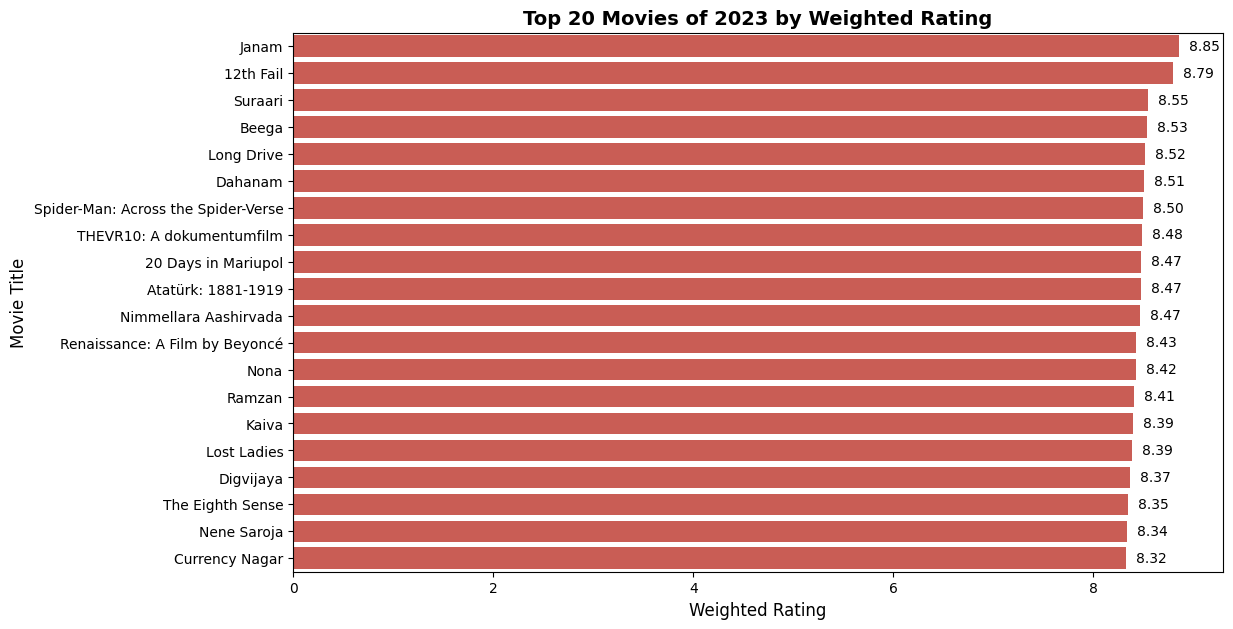

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort in PySpark first
top_20_sorted_spark = top_20_movies.orderBy("weightedRating", ascending=False)

# Convert to Pandas after sorting
top_20_sorted = top_20_sorted_spark.toPandas()

# Now plot
plt.figure(figsize=(12, 7))
sns.barplot(x="weightedRating", y="primaryTitle", data=top_20_sorted, color="#dc4c42")

# Add annotations (weighted scores)
for index, value in enumerate(top_20_sorted["weightedRating"]):
    plt.text(value + 0.1, index, f"{value:.2f}", color="black", va="center", fontsize=10)

plt.xlabel("Weighted Rating", fontsize=12)
plt.ylabel("Movie Title", fontsize=12)
plt.title("Top 20 Movies of 2023 by Weighted Rating", fontsize=14, fontweight='bold')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Define a colormap for genres
genre_colors = {
    "Drama": "red",
    "Action": "blue",
    "Comedy": "green",
    "Romance": "purple",
    "Thriller": "orange",
    "Biography": "cyan",
    "Crime": "brown",
    "Documentary": "yellow",
    "War": "black",
    "Music": "pink",
    "Family": "gray",
    "Adventure": "magenta"
}

# Ensure genres column is a list
top_20_movies["genres"] = top_20_movies["genres"].apply(lambda x: x if isinstance(x, list) else [x])

# Function to assign blended color based on multiple genres
def get_genre_color(genre_list):
    colors = [genre_colors.get(g, "white") for g in genre_list if g in genre_colors]
    
    if len(colors) == 1:
        return colors[0]  # Single color
    elif len(colors) == 2:
        return np.mean([plt.cm.colors.to_rgb(c) for c in colors], axis=0)  # Blend two colors
    elif len(colors) >= 3:
        return np.mean([plt.cm.colors.to_rgb(c) for c in colors[:3]], axis=0)  # Blend three colors
    return "white"  # Default color if no genres match

# Assign colors to each movie
top_20_movies["color"] = top_20_movies["genres"].apply(get_genre_color)

# Bubble size based on numVotes
bubble_size = np.sqrt(top_20_movies["numVotes"]) * 2  # Adjust for visibility

# Create bubble plot
plt.figure(figsize=(12, 8))
plt.scatter(
    top_20_movies["averageRating"],
    top_20_movies["weightedRating"],
    s=bubble_size,
    alpha=0.6,
    c=top_20_pd["color"].tolist(),
    edgecolors="black",
    linewidth=1.2
)

# Labels and grid
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Weighted Rating", fontsize=12)
plt.title("Top 20 Movies: Average Rating vs Weighted Rating", fontsize=14, fontweight='bold')
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

In [29]:
# Get the top 20 movies based on average rating alone
top_20_avg_rating = movie_ratings_2023.orderBy(col("averageRating").desc()).limit(20)

top_20_avg_rating.show()

+----------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|    tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|averageRating|numVotes|
+----------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+-------------+--------+
|tt26470758|    movie|       Vida de Atriz|       Vida de Atriz|      0|     2023|   NULL|            77|               Drama|         10.0|       7|
|tt21065098|    movie|Prince Oak Oakley...|Prince Oak Oakley...|      0|     2023|   NULL|            60|                NULL|         10.0|      32|
|tt27529215|    movie|             Bindori|             Bindori|      0|     2023|   NULL|          NULL|                NULL|         10.0|       8|
|tt26680820|    movie|          COMPLEXion|          COMPLEXion|      0|     2023|   NULL|          

### 2. Most Popular Actors/Actresses in 2023

Defining a Popularity Metric for Actors in 2023
To determine the most popular actors, we need a metric that balances both audience engagement (votes) and critical reception (ratings). A straightforward approach is a weighted popularity score:

Popularity Score = [V/(𝑉+𝑀)]𝑅 + [𝑀/(𝑉+𝑀)]𝐶

Where:

𝑉 = Total number of votes the actor received across all movies.
𝑅 = Average rating across the actor's movies.
𝑀 = A vote threshold (e.g., 75th percentile of total votes across actors).
𝐶 = Mean rating of all actors in 2023.

This formula is similar to IMDb's weighted rating but applied to actors instead of movies.

In [ ]:
from pyspark.sql.functions import col, avg, sum, count, lit

# Step 1 & 2: Use previously filtered 2023 movies merged with ratings
movie_ratings_2023.show()

In [ ]:
# Step 3: Join with principals to get actors/actresses
cast_2023 = movie_ratings_2023.join(
    imdb_principals_filtered.filter(col("category").isin(["actor", "actress"])),
    "tconst",
    "inner"
)

In [ ]:
# Step 4: Join with names dataset to get actor details
actors_2023 = cast_2023.join(imdb_names, "nconst", "inner")

In [ ]:
# Step 5: Aggregate votes and ratings per actor
actor_popularity = actors_2023.groupBy("primaryName").agg(
    sum("numVotes").alias("totalVotes"),  # Total number of votes across movies
    avg("averageRating").alias("avgRating")  # Average rating of movies
)

In [ ]:
# Step 6: Compute vote threshold (M) and mean rating (C)
C = actor_popularity.select(avg("avgRating")).collect()[0][0]  # Mean actor rating
M = actor_popularity.approxQuantile("totalVotes", [0.75], 0.01)[0]  # 75th percentile of votes

In [ ]:
# Step 7: Compute Popularity Score
actor_popularity = actor_popularity.withColumn(
    "popularityScore",
    (col("totalVotes") / (col("totalVotes") + lit(M))) * col("avgRating") +
    (lit(M) / (col("totalVotes") + lit(M))) * lit(C)
)

In [ ]:
# Step 8: Get top 20 most popular actors
top_20_actors = actor_popularity.orderBy(col("popularityScore").desc()).limit(20)

top_20_actors.show()

Why This Metric?
✅ Balances popularity and quality → High vote count alone doesn’t make an actor great. <br> ✅ Accounts for audience size → More votes = more engagement. <br> ✅ Controls for extreme ratings → A single highly-rated but low-vote movie won’t dominate. <br> ✅ Industry relevance → Movie studios care about both audience reception and critical approval.

### 3. User-Movie Trends

### 4. Metric of a 'Hit Movie'

<h2 style="color:#de4a48; background-color:#fce19a; padding: 10px; text-align:left; border: 1px solid #fce19a;">Predictive Modelling</h2>

<h2 style="color:#de4a48; background-color:#fce19a; padding: 10px; text-align:left; border: 1px solid #fce19a;">References</h2>

https://medium.com/@jingkunzler211/choosing-the-best-regression-model-imdb-movie-rating-prediction-3298fb11b6d

https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system/notebook

https://www.kaggle.com/code/rounakbanik/movie-recommender-systems

https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies

https://www.reddit.com/r/statistics/comments/1niai5/imbd_weighted_average/